### Importando as bibliotecas necessárias

In [13]:
# Importar bibliotecas
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
from PIL import Image
import matplotlib.pyplot as plt


### Verificando condições iniciais

In [14]:
print(f"Versão do TensorFlow: {tf.__version__}")

Versão do TensorFlow: 2.18.0


### Extração do dataset:

In [15]:
with zipfile.ZipFile('dataset/cats_and_dogs.zip', 'r') as zip_ref:
    zip_ref.extractall('cats_and_dogs')

### Diretórios principais

In [16]:
base_dir = 'cats_and_dogs/PetImages'
print(os.listdir(base_dir))


['Cat', 'Dog']


### Verificação e Exclusão Arquivos Corrompidos

In [17]:
def check_and_remove_corrupted_images(directory):
    num_deleted = 0
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verifica se a imagem é válida
            except (IOError, SyntaxError):
                print(f"Imagem corrompida removida: {file_path}")
                os.remove(file_path)
                num_deleted += 1
    print(f"Total de imagens corrompidas removidas: {num_deleted}")

# Caminho para o diretório do dataset
dataset_dir = "cats_vs_dogs/PetImages"

# Remover imagens corrompidas
check_and_remove_corrupted_images(dataset_dir)


Total de imagens corrompidas removidas: 0


### Sincronização do diretório

In [18]:
base_dir = "cats_and_dogs/PetImages"

# Listar arquivos na pasta de gatos
cat_dir = os.path.join(base_dir, "Cat")
print(f"Total de imagens na pasta 'Cat': {len(os.listdir(cat_dir))}")

# Verificar se o arquivo ausente existe
missing_file = os.path.join(cat_dir, "666.jpg")
if not os.path.exists(missing_file):
    print(f"Arquivo ausente: {missing_file}")


Total de imagens na pasta 'Cat': 12501


### Atualização do diretório do dataset e recriação do gerador

In [19]:
# Configurar o gerador de dados
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2  # Separar 20% para validação
)

# Criar gerador de treinamento e validação
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Limpeza de caminhos inconsistentes

In [20]:
def clean_invalid_files(directory):
    removed_files = 0
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                with Image.open(os.path.join(root, file)) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Removendo arquivo inválido: {file}")
                os.remove(os.path.join(root, file))
                removed_files += 1
    print(f"Total de arquivos removidos: {removed_files}")

clean_invalid_files(base_dir)


Removendo arquivo inválido: 666.jpg
Removendo arquivo inválido: Thumbs.db
Removendo arquivo inválido: 11702.jpg
Removendo arquivo inválido: Thumbs.db
Total de arquivos removidos: 4


### Treinamento do modelo

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Carregar o modelo base VGG16 com pesos pré-treinados no ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar os pesos do modelo base (não treinar as camadas da VGG16)
for layer in base_model.layers:
    layer.trainable = False

# Criar o modelo completo adicionando camadas personalizadas
model = Sequential([
    base_model,
    Flatten(),  # Achatar as saídas da VGG16
    Dense(128, activation='relu'),  # Camada totalmente conectada com 128 neurônios
    Dropout(0.5),  # Adicionar dropout para reduzir overfitting
    Dense(1, activation='sigmoid')  # Saída com ativação sigmoide para classificação binária
])

# Compilar o modelo
model.compile(
    optimizer='adam',  # Otimizador Adam
    loss='binary_crossentropy',  # Função de perda para classificação binária
    metrics=['accuracy']  # Métrica de avaliação
)

# Resumo do modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
# Remover imagens corrompidas
dataset_dir = "cats_and_dogs/PetImages"
check_and_remove_corrupted_images(dataset_dir)
clean_invalid_files(dataset_dir)

# Configurar o gerador de dados
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2  # Separar 20% para validação
)

# Criar gerador de treinamento e validação
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Total de imagens corrompidas removidas: 0
Total de arquivos removidos: 0
Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [24]:
# Recriar geradores após limpar arquivos corrompidos
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [25]:
# Garantir que todos os arquivos restantes são válidos
check_and_remove_corrupted_images(base_dir)


Total de imagens corrompidas removidas: 0


In [26]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1552s 2s/step - accuracy: 0.8986 - loss: 0.2377 - val_accuracy: 0.9112 - val_loss: 0.2227
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1414s 2s/step - accuracy: 0.9104 - loss: 0.2184 - val_accuracy: 0.9136 - val_loss: 0.2089
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1280s 2s/step - accuracy: 0.9199 - loss: 0.1923 - val_accuracy: 0.9126 - val_loss: 0.2064
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1236s 2s/step - accuracy: 0.9203 - loss: 0.1900 - val_accuracy: 0.9174 - val_loss: 0.1985
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1239s 2s/step - accuracy: 0.9261 - loss: 0.1762 - val_accuracy: 0.9116 - val_loss: 0.2097
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1361s 2s/step - accuracy: 0.9332 - loss: 0.1639 - val_accuracy: 0.9158 - val_loss: 0.2034
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1374s 2s/step - accuracy: 0.9352 - loss: 0.1489 - val_accuracy: 0.9108 - val_loss: 0.2159
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1380s 2s/step - accuracy: 0.9376 - loss: 0.1512 - 

### Avaliação dos resultados

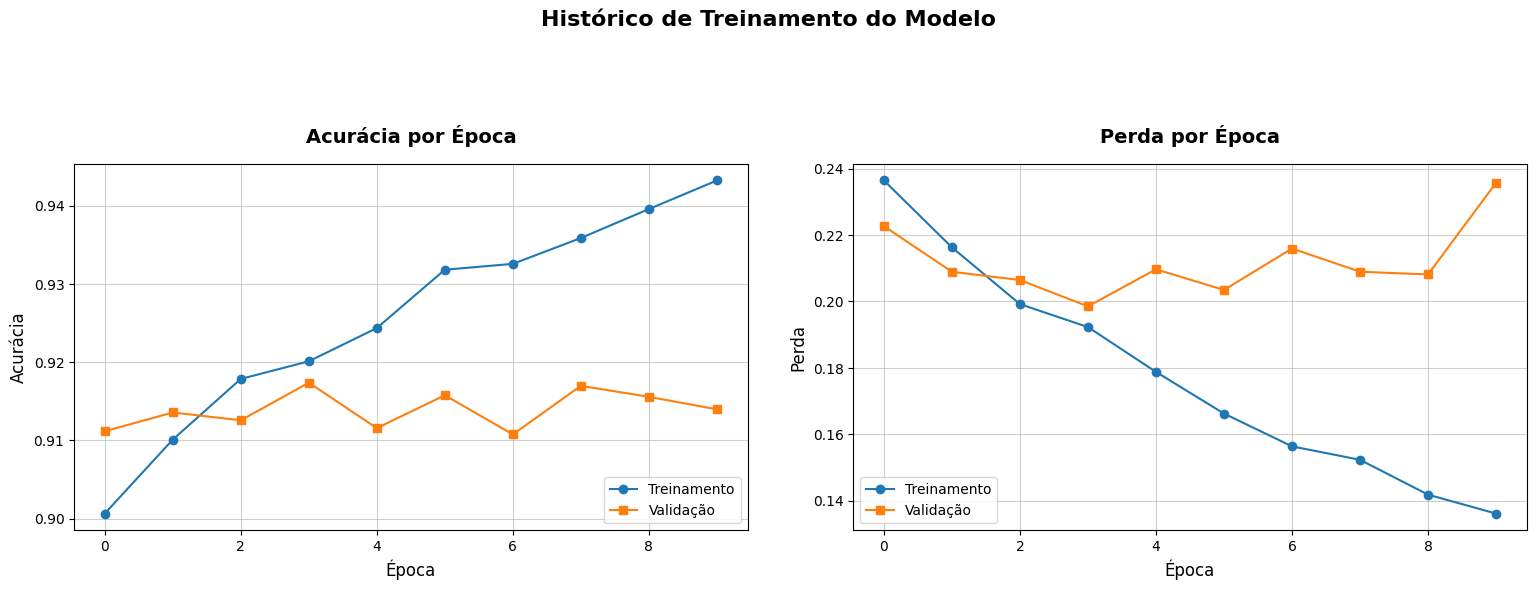

In [29]:
import matplotlib.pyplot as plt

# Plotando a acurácia e a perda do treinamento e validação
def plot_training_history(history):
    # Configuração global do estilo
    
    
    # Criar duas subplots: uma para acurácia, outra para perda
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
    
    # Plot da acurácia
    ax[0].plot(history.history['accuracy'], label='Treinamento', marker='o')
    ax[0].plot(history.history['val_accuracy'], label='Validação', marker='s')
    ax[0].set_title("Acurácia por Época", pad=15, fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Época", fontsize=12)
    ax[0].set_ylabel("Acurácia", fontsize=12)
    ax[0].legend(loc='lower right', fontsize=10)
    ax[0].grid(alpha=0.6)
    
    # Plot da perda
    ax[1].plot(history.history['loss'], label='Treinamento', marker='o')
    ax[1].plot(history.history['val_loss'], label='Validação', marker='s')
    ax[1].set_title("Perda por Época", pad=15, fontsize=14, fontweight='bold')
    ax[1].set_xlabel("Época", fontsize=12)
    ax[1].set_ylabel("Perda", fontsize=12)
    ax[1].legend(loc='lower left', fontsize=10)
    ax[1].grid(alpha=0.6)
    
    # Espaçamento entre os subplots e título principal
    fig.suptitle("Histórico de Treinamento do Modelo", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(pad=3.0)
    plt.show()

# Chamando a função com o histórico do treinamento
plot_training_history(history)
